<a href="https://colab.research.google.com/github/pockerman/hidden_markov_modeling/blob/master/stories/story_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Story 57


Chromosome 17


Apply ```HMM_Model_9.json``` in regions: 

* [R1: ```region_0_REGION_1_CHR_17_MEAN_CUTOFF.txt```,  1000000-20000000](#r1)
* [R2: ```region_0_REGION_2_CHR_17_MEAN_CUTOFF.txt```,  30000000-40000000](#r2) 
* [R3: ```region_0_REGION_3_CHR_17_MEAN_CUTOFF.txt```,  40000000-60000000](#r3)
* [R4: ```region_0_REGION_4_CHR_17_MEAN_CUTOFF.txt```,  60000000-80000000](#r4)


In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
from pomegranate import *
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from helpers import read_configuration_file, INFO, WARNING
from hmm_helpers import build_hmm
from helpers import WindowType
from preprocess_utils import get_distributions_list_from_names as get_dist_list
from region import Region

In [4]:
from notebooks_helpers import filter_viterbi_path
from notebooks_helpers import save_segments
from notebooks_helpers import load_data_file
from notebooks_helpers import get_start_end_segment
from notebooks_helpers import make_data_array
from notebooks_helpers import gmm_clustering
from notebooks_helpers import create_viterbi_path
from notebooks_helpers import create_states
from notebooks_helpers import create_tuf_state
from notebooks_helpers import get_states_counter
from notebooks_helpers import plot_hmm_states_to_labels
from notebooks_helpers import plot_hmm_label_state
from notebooks_helpers import plot_hmm_cluster_contours

In [5]:
sns.set(color_codes=True)

Orphan state HMM_Model-start removed due to no edges                             leading to it
Orphan state HMM_Model-end removed due to no edges                             leading to it


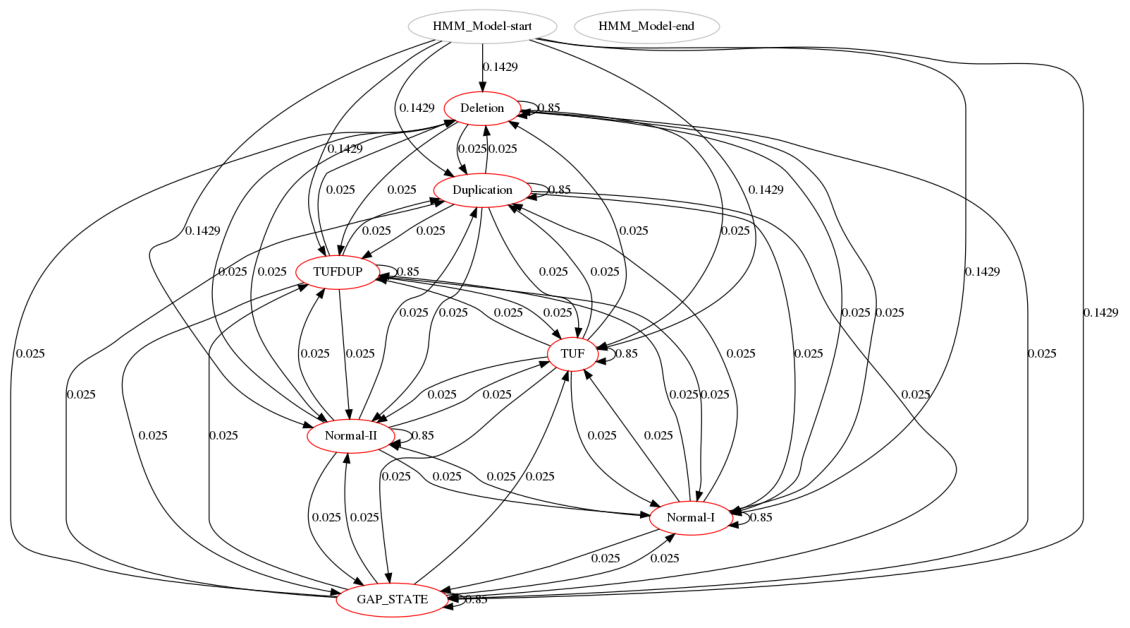

In [6]:
# load the configuration
configuration = read_configuration_file("../config.json")
hmm_config = configuration["HMM"]
hmm_filename = "HMM_Model_9.json"
hmm_model = build_hmm(hmm_file=hmm_filename)
# visualize the model we just trained
plt.figure( figsize=(20,18) )
hmm_model.plot()
plt.show()

## <a name="r1"></a>  Region 1

In [7]:
chr='chr17'
viterbi_paths = 'viterbi_paths_chr17/'


In [8]:
# load the region we want to use for prediction
region_name = "region_0_REGION_1_CHR_17_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_1_CHR_17_MEAN_CUTOFF.txt
Sequence length:  190000


In [9]:
filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model,
                                                                         chr=chr,
                                                                         filename=filename)

Observation length:  190000
Done. Execution time 0.6846519749997242 secs
Log-probability of ML Viterbi path:  -1282005.643449483
Viterbi path length:  190001
There should be 0 gaps


In [10]:
# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

Length of path  190000
Length of TUF+DELETION+TUF state:  1147


In [11]:
wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

Length of WGA Observations:  190000
Encountered gaps:  0


In [12]:
states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

{'Duplication': 79, 'Normal-I': 134073, 'Normal-II': 52136, 'Deletion': 188, 'Single-Deletion': 0, 'TUF': 3524, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


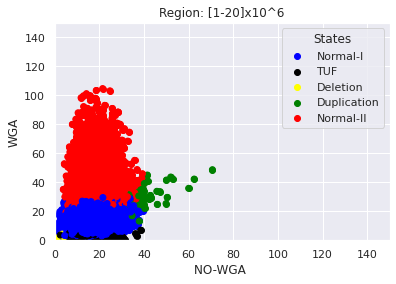

HMM labels color:  {'blue': [1, 134073], 'black': [5, 3524], 'yellow': [3, 188], 'green': [0, 79], 'red': [2, 52136]}


In [13]:
hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [1-20]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

In [14]:
for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

State:  Duplication
WGA mean/var:  28.595316455696207 42.45864008972921
NO-WGA mean/var:  37.519620253164554 63.951274539336666
State:  Normal-I
WGA mean/var:  15.884077778523636 27.825437818180585
NO-WGA mean/var:  16.684442356029926 21.305436087301313
State:  Normal-II
WGA mean/var:  32.56452969157588 78.98226580228705
NO-WGA mean/var:  17.95746950283873 19.93771611653195
State:  Deletion
WGA mean/var:  1.3547872340425535 1.927868571751924
NO-WGA mean/var:  2.070159574468085 1.65612071921684
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.6885754824063564 2.4734246449834507
NO-WGA mean/var:  13.8636123723042 22.543749237940002
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


## <a name="r2"></a> Region 2

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_2_CHR_17_MEAN_CUTOFF.txt
Sequence length:  99976
Observation length:  99976
Done. Execution time 0.4298223000005237 secs
Log-probability of ML Viterbi path:  -689610.0264830285
Viterbi path length:  99977
There should be 0 gaps
Length of path  99976
Length of TUF+DELETION+TUF state:  21
Length of WGA Observations:  99976
Encountered gaps:  0
{'Duplication': 241, 'Normal-I': 68225, 'Normal-II': 31136, 'Deletion': 70, 'Single-Deletion': 0, 'TUF': 304, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


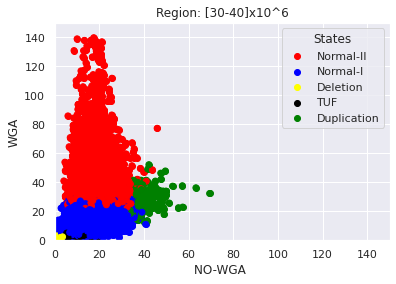

HMM labels color:  {'red': [2, 31136], 'blue': [1, 68225], 'yellow': [3, 70], 'black': [5, 304], 'green': [0, 241]}
State:  Duplication
WGA mean/var:  27.606929460580915 47.36584866307398
NO-WGA mean/var:  38.39589211618257 40.54443831201254
State:  Normal-I
WGA mean/var:  15.847752729937705 27.27810227407188
NO-WGA mean/var:  17.102950677903994 22.993523017941097
State:  Normal-II
WGA mean/var:  34.6099049331963 139.59899192955427
NO-WGA mean/var:  17.9092253340185 19.640881600560657
State:  Deletion
WGA mean/var:  1.7459999999999998 1.249981142857143
NO-WGA mean/var:  2.177285714285714 1.638396918367347
State:  Single-Deletion
State:  TUF
WGA mean/var:  3.3748026315789477 1.5135071978878116
NO-WGA mean/var:  10.23700657894737 15.519394657851452
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [15]:
# load the region we want to use for prediction
region_name = "region_0_REGION_2_CHR_17_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [30-40]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r3"></a>  Region 3

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_3_CHR_17_MEAN_CUTOFF.txt
Sequence length:  199985
Observation length:  199985
Done. Execution time 0.7156195140014461 secs
Log-probability of ML Viterbi path:  -1367784.064100022
Viterbi path length:  199986
There should be 0 gaps
Length of path  199985
Length of TUF+DELETION+TUF state:  502
Length of WGA Observations:  199985
Encountered gaps:  0
{'Duplication': 367, 'Normal-I': 140739, 'Normal-II': 57110, 'Deletion': 522, 'Single-Deletion': 0, 'TUF': 1247, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


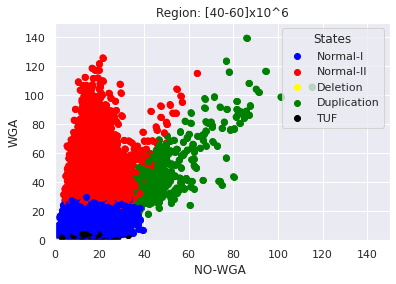

HMM labels color:  {'blue': [1, 140739], 'red': [2, 57110], 'yellow': [3, 522], 'green': [0, 367], 'black': [5, 1247]}
State:  Duplication
WGA mean/var:  45.55474114441416 426.9218222081981
NO-WGA mean/var:  47.64877384196185 220.9054151177899
State:  Normal-I
WGA mean/var:  16.20175132692431 26.543558278323278
NO-WGA mean/var:  17.183725903978292 23.5308959436295
State:  Normal-II
WGA mean/var:  33.03331675713536 92.77607506110778
NO-WGA mean/var:  17.927450008755034 21.249349762647082
State:  Deletion
WGA mean/var:  1.4191954022988507 2.0712288545382482
NO-WGA mean/var:  1.365574712643678 1.8373951677896683
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.9314033680834 2.249636282362353
NO-WGA mean/var:  13.160216519647154 26.88615881438628
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [16]:
# load the region we want to use for prediction
region_name = "region_0_REGION_3_CHR_17_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [40-60]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r4"></a>  Region 4

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_4_CHR_17_MEAN_CUTOFF.txt
Sequence length:  200000
Observation length:  200000
Done. Execution time 0.5754941870000039 secs
Log-probability of ML Viterbi path:  -1343440.35375154
Viterbi path length:  200001
There should be 0 gaps
Length of path  200000
Length of TUF+DELETION+TUF state:  1090
Length of WGA Observations:  200000
Encountered gaps:  0
{'Duplication': 58, 'Normal-I': 152136, 'Normal-II': 44427, 'Deletion': 170, 'Single-Deletion': 0, 'TUF': 3209, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


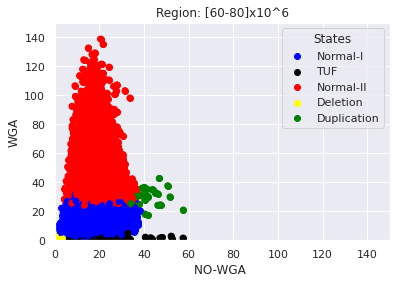

HMM labels color:  {'blue': [1, 152136], 'black': [5, 3209], 'red': [2, 44427], 'yellow': [3, 170], 'green': [0, 58]}
State:  Duplication
WGA mean/var:  27.283793103448275 27.86356837098692
NO-WGA mean/var:  36.91051724137931 40.55868076694411
State:  Normal-I
WGA mean/var:  15.609067742020297 27.32715181467799
NO-WGA mean/var:  17.1230738286796 21.863132982034205
State:  Normal-II
WGA mean/var:  32.8018450491818 111.0716987251293
NO-WGA mean/var:  18.054142751029776 19.644661953917055
State:  Deletion
WGA mean/var:  0.8471764705882352 1.0515684982698963
NO-WGA mean/var:  2.059235294117647 1.992182356401384
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.4925708943596137 2.487529164886735
NO-WGA mean/var:  14.453156746650045 24.214542574682593
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [17]:
# load the region we want to use for prediction
region_name = "region_0_REGION_4_CHR_17_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [60-80]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))